In [1]:

import numpy as np
import pandas as pd
import random
import seaborn as sns
# import torch
# import tqdm
# import prompting
# from transformers import (
#     GPT2LMHeadModel, 
#     GPT2Tokenizer, 
#     RobertaForMaskedLM, 
#     RobertaTokenizer, 
#     T5ForConditionalGeneration,
#     T5Tokenizer
# )
# import helpers
# import pandas as pd
import itertools
# import openai
# from openai import OpenAI

# from torch.nn import functional as F
# from transformers import T5Tokenizer, T5ForConditionalGeneration


In [2]:
predictions_df = pd.read_csv("../data/output/sex_gender_prompting_output.csv")

In [5]:
# All models:
all_models = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "roberta-base", "roberta-large", "t5-small", "t5-base", "t5-large", "t5-3b"]
# all_models = ["gpt2", "roberta-base", "t5-base"]

In [6]:
sex_characteristics = {
    "male":["is male", "is"], 
    "female":["is female","is"],
    "intersex":["is intersex","is"],
    "penis":["has a penis","has a"], 
    "vagina":["has a vagina","has a"], 
    "prostate":["has a prostate","has a"], 
    "uterus":["has a uterus","has a"], 
    "testosterone":["has testosterone","has"], 
    "estrogen":["has estrogen","has"],
    # "sperm":["has sperm","has"],
    # "menstruating":["is menstruating","is"], 
    # "menopause":["is in menopause","is in"],
    "XY":["has XY chromosomes","has"], 
    "XX":["has XX chromosomes","has"]#, 
    # "XO":["has XO chromosomes","has"], 
    # "XXY":["has XXY chromosomes","has"], 
    # "XYY":["has XYY chromosomes","has"], 
    # "XXX":["has XXX chromosomes","has"]
}

gender_words = [
    "man",
    "woman",
    "transgender person",
    "nonbinary person"#,
    # "cisgender person",
    # "genderqueer person",
    # "agender person",
    # "bigender person",
    # "pangender person",
    # "genderfluid person",
    # "gender-neutral person",
    # "gender-nonconforming person",
    # "androgynous person",
    # "demiboy",
    # "demigirl",
    # "two-spirit person",
    # "third gender person"
]

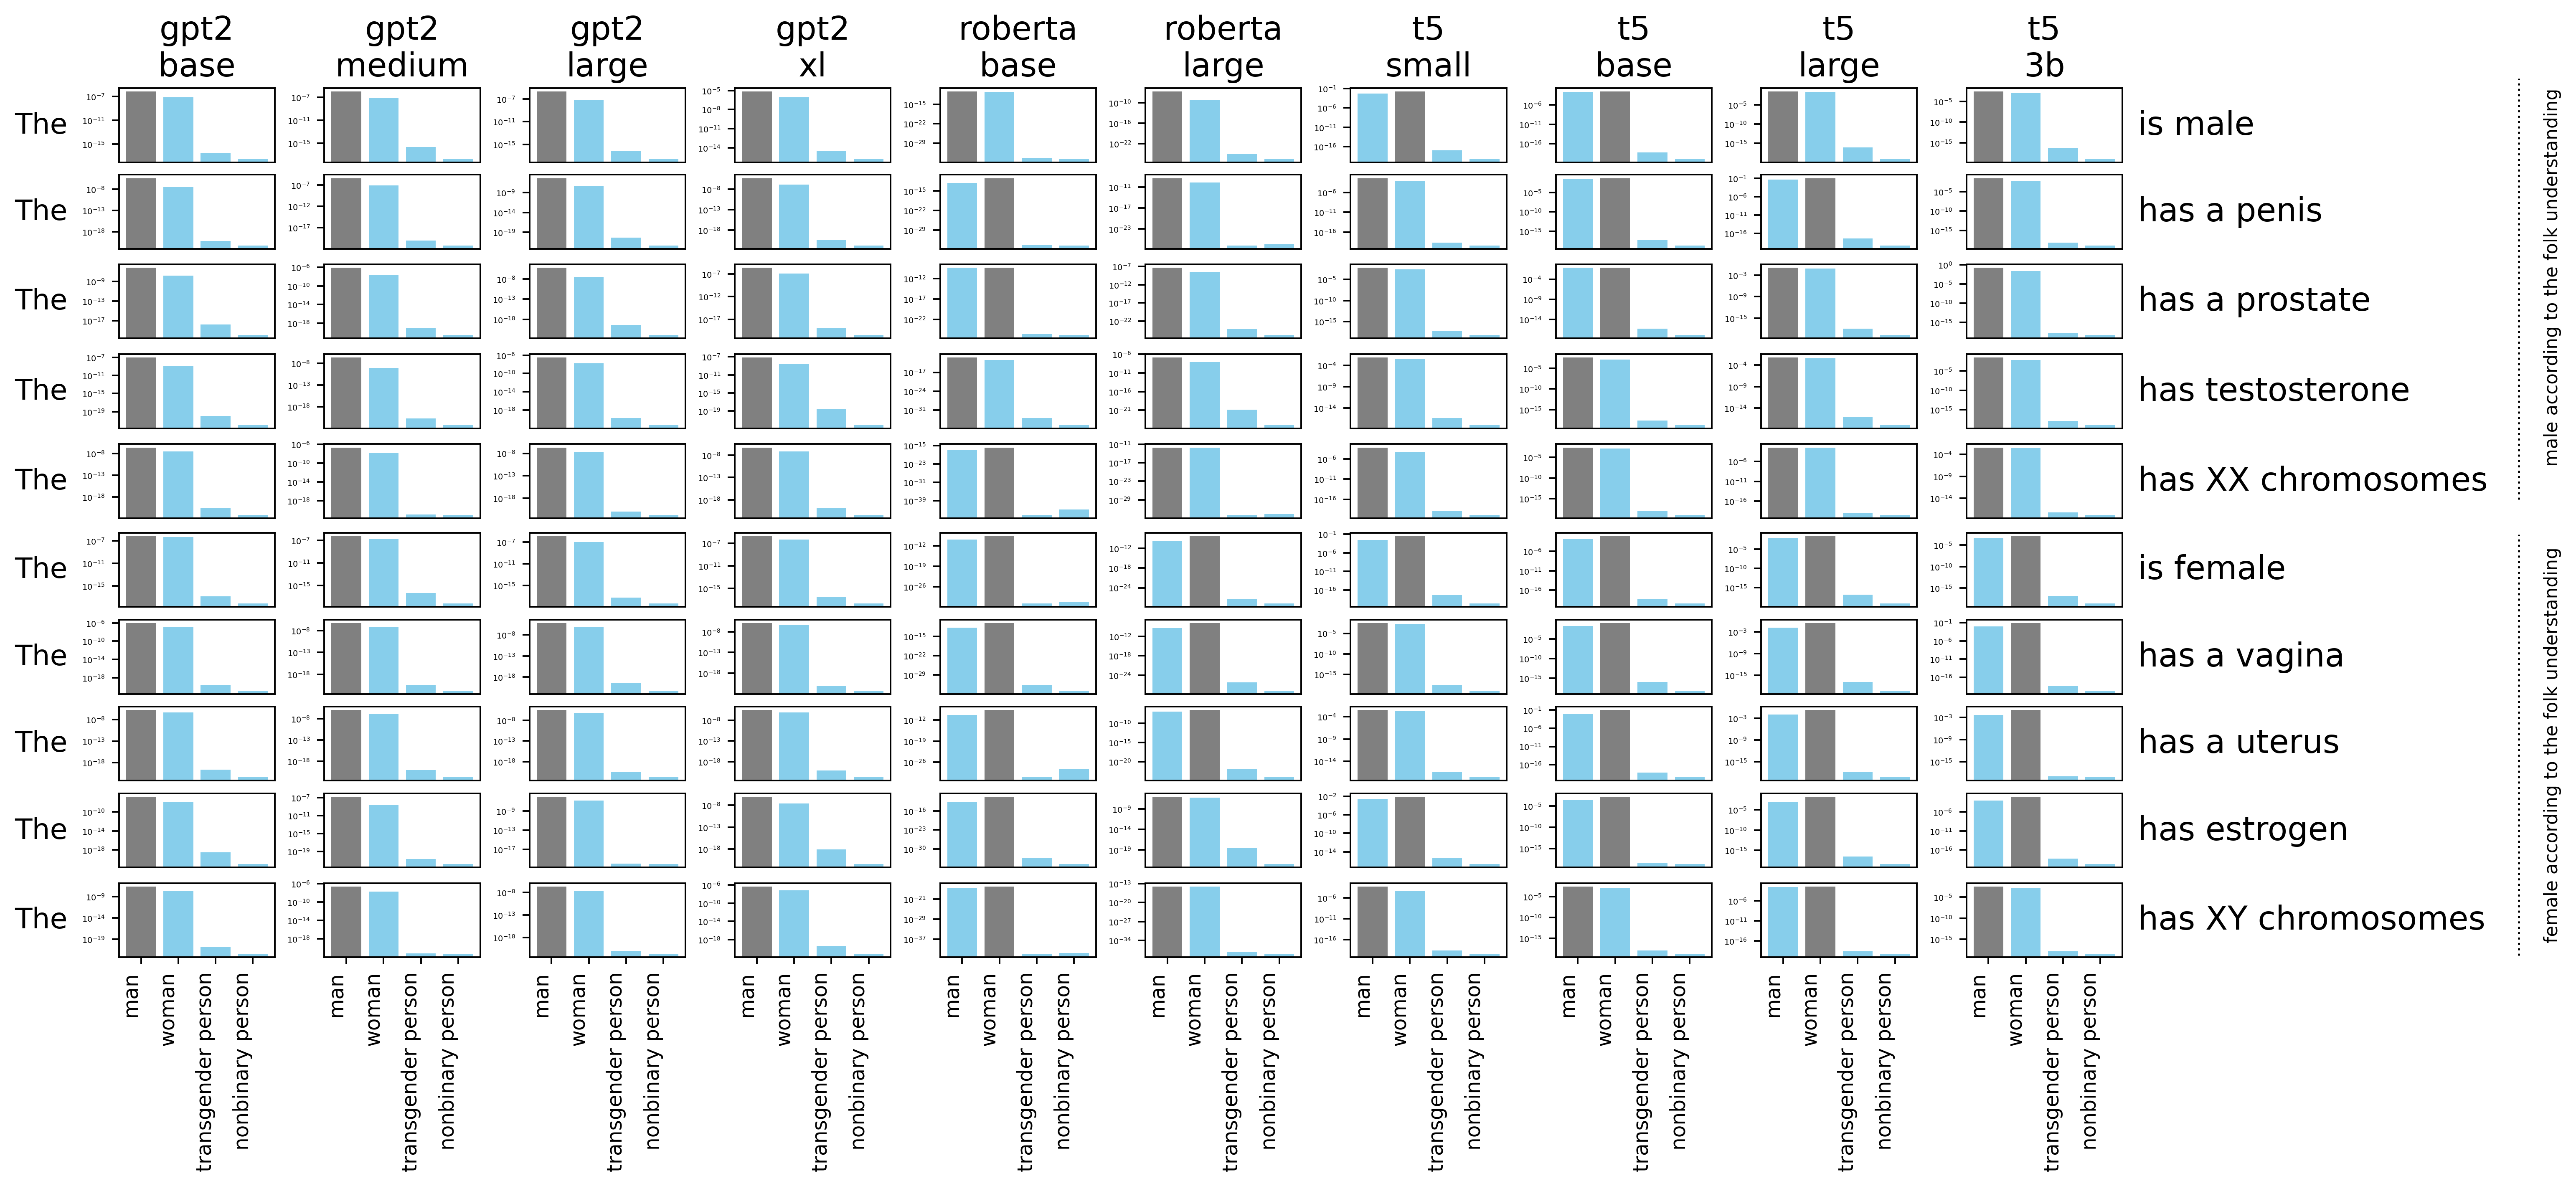

In [8]:
import numpy as np
import matplotlib.pyplot as plt

gender_words = ["man", "woman", "transgender person", "nonbinary person"]

def plot_multiple_gender_word_probabilities(predictions_df, all_models, all_sex_characteristics, gender_words, sex_characteristics, save_path="../visualisations/gender_word_probabilities.png"):
    """
    Plots a row of bar charts for each sex characteristic in `all_sex_characteristics`, 
    with one column per model in `all_models`.
    
    Parameters:
        predictions_df (pd.DataFrame): DataFrame containing log-probabilities for different gender words.
        all_models (list): List of model names to create individual columns of plots for.
        all_sex_characteristics (list): List of sex characteristics to create individual rows for.
        gender_words (list): Ordered list of gender words to ensure consistent order in plots.
        sex_characteristics (dict): Dictionary with descriptions of sex characteristics.
        save_path (str): Path to save the generated plot image.
    """
    num_characteristics = len(all_sex_characteristics)
    num_models = len(all_models)
    
    fig, axes = plt.subplots(num_characteristics, num_models, figsize=(1.7 * num_models, 0.8 * num_characteristics), dpi=350, constrained_layout=True)
    # fig, axes = plt.subplots(num_characteristics, num_models, figsize=(1.7 * num_models + 2, 0.8 * num_characteristics), dpi=350, constrained_layout=True)

    # Ensure axes is always 2D for consistent indexing
    if num_characteristics == 1:
        axes = [axes]
    if num_models == 1:
        axes = [[ax] for ax in axes]

    for i, sex_characteristic in enumerate(all_sex_characteristics):
        for j, model_name in enumerate(all_models):
            ax = axes[i][j]
            df_filtered = predictions_df[
                (predictions_df['model_name'] == model_name) & 
                (predictions_df['sex_characteristic'] == sex_characteristic)
            ]

            # Convert log probabilities to probabilities
            df_plot = df_filtered.drop(columns=['model_name', 'sex_characteristic']).T
            df_plot.columns = ['probability']
            df_plot['probability'] = np.exp(df_plot['probability'])  # Convert log probabilities to probabilities

            df_plot = df_plot.reindex(gender_words)
            
            # Determine bar colors: dark blue for the highest bar, skyblue for others
            bar_colors = ["grey" if p == df_plot['probability'].max() else "skyblue" for p in df_plot['probability']]
            ax.bar(df_plot.index, df_plot['probability'], color=bar_colors)
            ax.set_yscale("log")
            ax.tick_params(axis='y', labelsize=4)  
            
            # Add model title to the top row, split at '-'
            if i == 0:
                if '-' in model_name:
                    split_model_name = model_name.replace('-', '\n')  # Split model name on '-' character
                else:
                    split_model_name = f"{model_name}\nbase"  # Add 'base' to the second line if no '-'
                ax.set_title(split_model_name, fontsize=16)
            
            # Add labels for the first column and last column
            if j == 0:
                ax.text(-0.5, 0.5, "The", transform=ax.transAxes, fontsize=14, ha='center', va='center')
            if j == num_models - 1:
                ax.text(1.1, 0.5, f"{sex_characteristics[sex_characteristic][0]}", transform=ax.transAxes, fontsize=16, ha='left', va='center')
            
            # Set x-tick labels only on the bottom row
            if i == num_characteristics - 1:
                ax.set_xticks(range(len(gender_words)))
                ax.set_xticklabels(gender_words, rotation=90, ha="right")
            else:
                ax.set_xticks([])

    fig.text(1.02, 0.77, "male according to the folk understanding", rotation=90, va="center", ha="left", fontsize=9)
    fig.lines.append(plt.Line2D([1.01, 1.01], [0.58, 0.94], transform=fig.transFigure, color="black", linestyle=":", linewidth=1))
    
    fig.text(1.02, 0.37, "female according to the folk understanding", rotation=90, va="center", ha="left", fontsize=9)
    fig.lines.append(plt.Line2D([1.01, 1.01], [0.19, 0.55], transform=fig.transFigure, color="black", linestyle=":", linewidth=1))

    # Save the plot
    # plt.savefig(save_path, format='png')
    plt.savefig(save_path, format='png', bbox_inches="tight")
    plt.show()

# Example call to the function
ordered_sex_characteristics = ['male',  'penis', 'prostate', 'testosterone',  'XX', 'female', 'vagina', 'uterus', 'estrogen', 'XY']
plot_multiple_gender_word_probabilities(predictions_df, all_models, ordered_sex_characteristics, gender_words, sex_characteristics)
